# Optimization Techniques in Machine Learning


A Notebook detailing the following

* Loan Approval Classification model
* Dataset source:https://www.kaggle.com/code/youssefelbadry10/loan-approval-classification-eda-ml

the dataset contains 14 Colums colected using different methods











# Case Study and Implementation




In [11]:
# Import Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import xgboost as xgb
from imblearn.over_sampling import ADASYN
from sklearn.metrics import roc_curve, auc
import joblib

# The Dataset
> ***Brief Description:***
The project aim at developing a machine learning-based loan
classification system to assist financial institutions in determining the loan approval.


In [2]:
# Load Data
df = pd.read_csv("loan_data.csv")

# Display basic info and check for null values
df.info()
df.isnull().sum()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1



# Identify categorical columns
then change it to numerical data to make the preprocessing

In [3]:
# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Apply Label Encoding for binary categorical columns
label_encoders = {}
for col in categorical_cols:
    if df[col].nunique() == 2:  # If only two unique values, use Label Encoding
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

# Apply One-Hot Encoding for non-binary categorical columns
df = pd.get_dummies(df, columns=[col for col in categorical_cols if df[col].nunique() > 2])

In [4]:
df["loan_status"].value_counts()

,count
loan_status,
0,35000
1,10000


# class inbalance

when we see the target variable count we see that it is inbalanced data so I have impliment the ADASYN (Adaptive Synthetic Sampling) algorithm to balance the data

In [5]:
NUM_OF_ROWS = 80000
samples_per_class = NUM_OF_ROWS // df['loan_status'].nunique()

strategy = {loan_status: samples_per_class for loan_status in df['loan_status'].unique()}
adasyn = ADASYN(sampling_strategy=strategy, random_state=42)

X = df.drop('loan_status', axis=1)
y = df['loan_status']

X_resampled, y_resampled = adasyn.fit_resample(X, y)

augmented_df = pd.DataFrame(X_resampled, columns=X.columns)
augmented_df['loan_status'] = y_resampled

df = augmented_df

# 6. Verify:
print("df shape:", df.shape)
print(df['loan_status'].value_counts())

df shape: (77271, 26)
loan_status
1    39751
0    37520
Name: count, dtype: int64


In [6]:
# Separate features and target variable
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Split Data into Train, Validation, and Test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardization (Apply after encoding)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

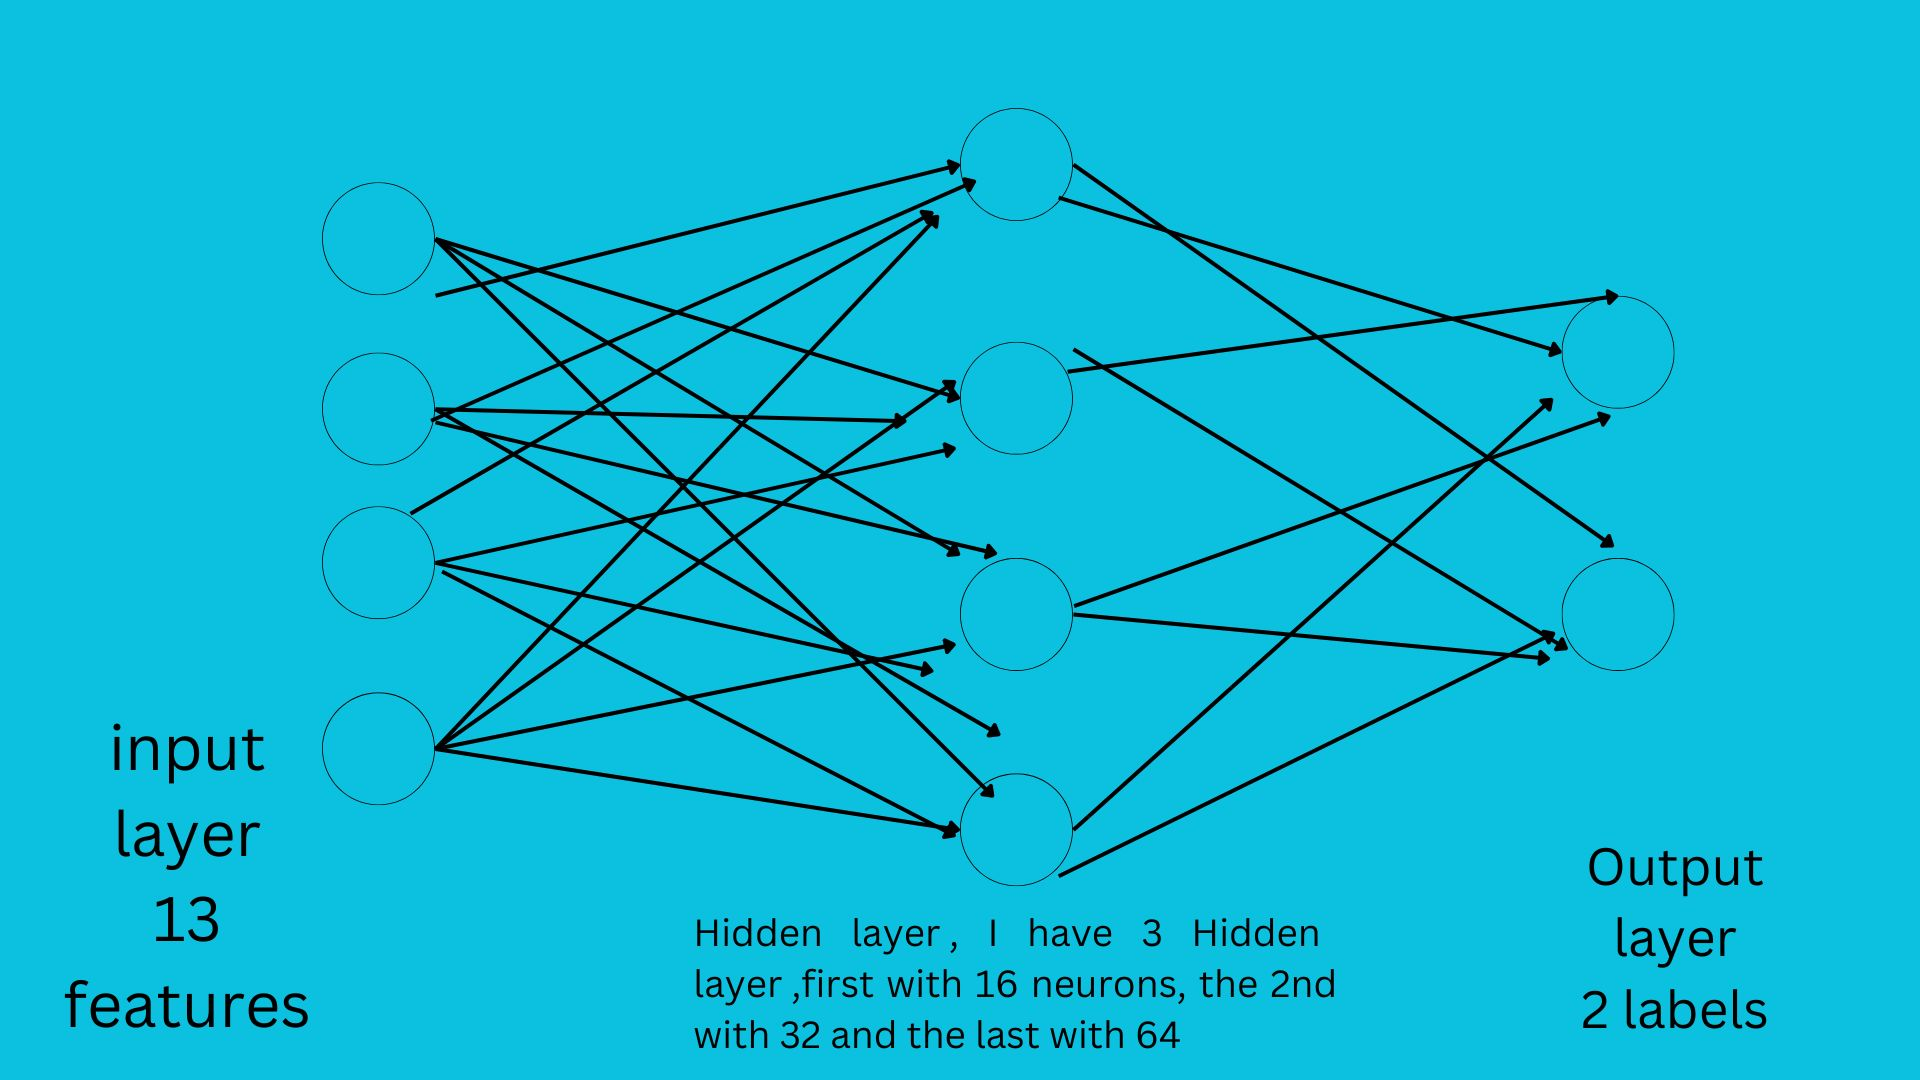

#Task: Define a function that creates models without and With specified Optimization techniques


In [7]:
def define_model(optimizer='sgd', early_stopping: bool = False, learning_rate: float = 0.001):
    model = Sequential()

    # Input layer
    model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))

    # Hidden layer
    model.add(Dense(32, activation='relu'))

    # Hidden layer
    model.add(Dense(64, activation='relu'))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))  # Last Layer

    # Define the optimizer
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unsupported optimization technique: {optimizer}")

    # Compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Define early stopping if required
    callbacks = []
    if early_stopping:
        callbacks.append(EarlyStopping(monitor='val_loss', patience=5))

    return model, callbacks

# Function to train and evaluate the neural network model
def train_and_evaluate_model(model, callbacks, X_train, y_train, X_val, y_val, X_test, y_test, epochs=10, model_name="model"):
    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=callbacks, verbose=1)

    # Evaluate the model on the test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    # Get predictions for additional metrics
    y_pred_prob = model.predict(X_test)  # Get probability scores
    y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to class labels

    # Compute metrics
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    # Print all metrics
    print(f"\nFinal Model Metrics for {model_name}:")
    print(f"Accuracy: {test_accuracy * 100:.2f}%")
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")

    # Plot the loss curve
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curve for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()


    # Return the model and metrics for comparison
    return {
        'Model Name': model_name,
        'Model': model,
        'Accuracy': test_accuracy,
        'F1 Score': f1,
        'Recall': recall,
        'Precision': precision
    }


# Task: Print out the Final Model Accuracy and plot the Loss curve

# Train Logistic Regression model

In [8]:
# Train Logistic Regression model
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train, y_train)

LogisticRegression()

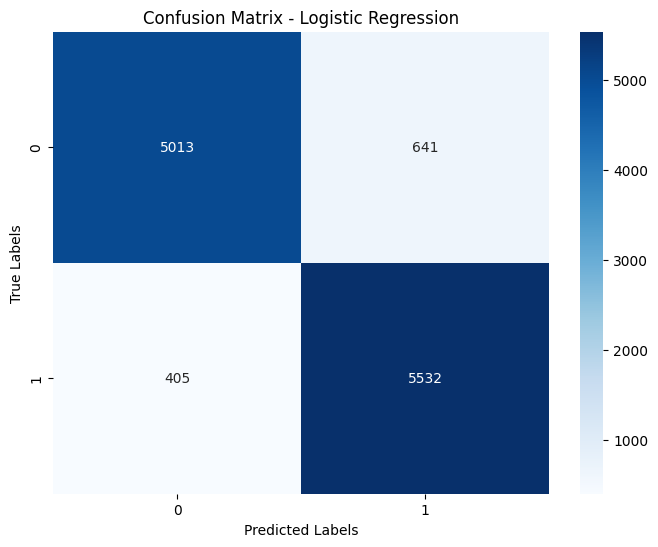


Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.89      0.91      5654
           1       0.90      0.93      0.91      5937

    accuracy                           0.91     11591
   macro avg       0.91      0.91      0.91     11591
weighted avg       0.91      0.91      0.91     11591



In [9]:
# Make predictions
y_pred = logistic_regression_model.predict(X_test)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Print classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Save logistic regression model

In [13]:
# Save logistic regression model
joblib.dump(logistic_regression_model, "logistic_regression_model.pkl")
print("Logistic Regression model saved as 'logistic_regression_model.pkl'.")

Logistic Regression model saved as 'logistic_regression_model.pkl'.


# Train and evaluate the optimized neural network model


Training Optimized Neural Network Model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8711 - loss: 0.2898 - val_accuracy: 0.9184 - val_loss: 0.1948
Epoch 2/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9232 - loss: 0.1849 - val_accuracy: 0.9236 - val_loss: 0.1800
Epoch 3/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9272 - loss: 0.1756 - val_accuracy: 0.9261 - val_loss: 0.1702
Epoch 4/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9325 - loss: 0.1647 - val_accuracy: 0.9288 - val_loss: 0.1673
Epoch 5/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9319 - loss: 0.1610 - val_accuracy: 0.9291 - val_loss: 0.1655
Epoch 6/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9334 - loss: 0.1599 - val_accuracy: 0.9317 - val_loss: 0.1624
Epoch 7/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9376 - loss: 0.1513 - val_accuracy: 0.9304 - val_loss: 0.1623
Epoch 8/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9358 - loss: 0.1544 - 

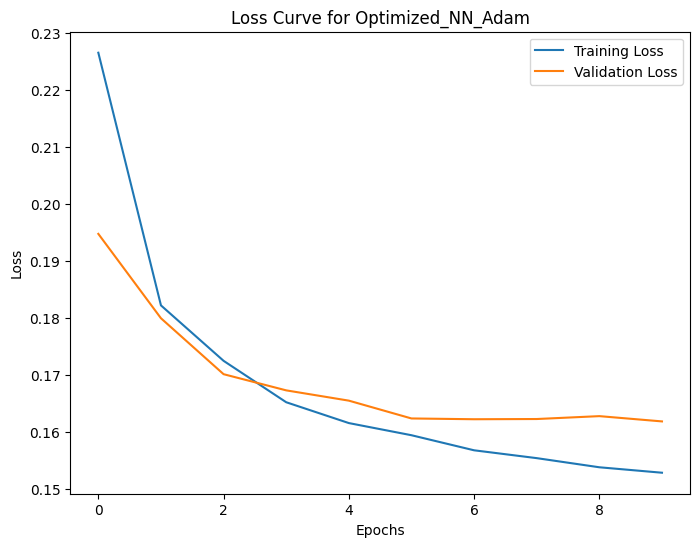

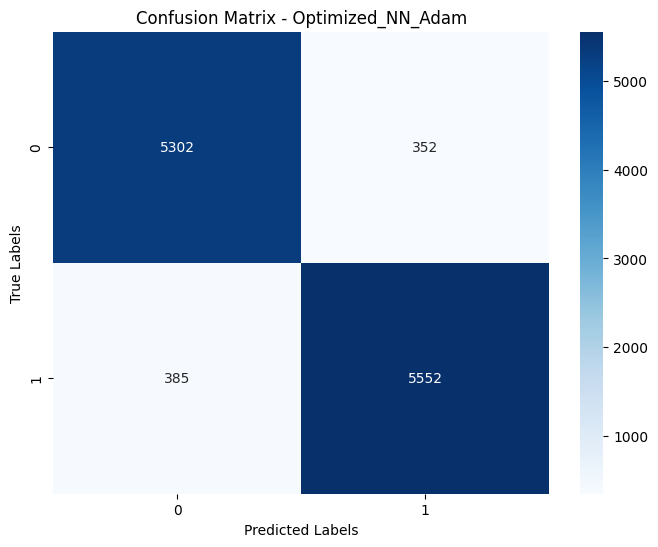

In [14]:
# Train and evaluate the optimized neural network model
print("\nTraining Optimized Neural Network Model...")
optimized_model, callbacks = define_model(optimizer='adam', early_stopping=True, learning_rate=0.001)
optimized_metrics = train_and_evaluate_model(optimized_model, callbacks, X_train, y_train, X_val, y_val, X_test, y_test, model_name="Optimized_NN_Adam")

# Train and evaluate the model with SGD optimizer


Training Neural Network Model with SGD Optimizer...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1691/1691 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.4878 - loss: 0.7173 - val_accuracy: 0.6314 - val_loss: 0.6569
Epoch 2/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6658 - loss: 0.6392 - val_accuracy: 0.7320 - val_loss: 0.5801
Epoch 3/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7509 - loss: 0.5551 - val_accuracy: 0.7948 - val_loss: 0.4796
Epoch 4/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8087 - loss: 0.4537 - val_accuracy: 0.8417 - val_loss: 0.3878
Epoch 5/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8516 - loss: 0.3672 - val_accuracy: 0.8683 - val_loss: 0.3233
Epoch 6/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8735 - loss: 0.3134 - val_accuracy: 0.8813 - val_loss: 0.2849
Epoch 7/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8862 - loss: 0.2772 - val_accuracy: 0.8896 - val_loss: 0.2624
Epoch 8/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8907 - loss: 0.2612 - val_accurac

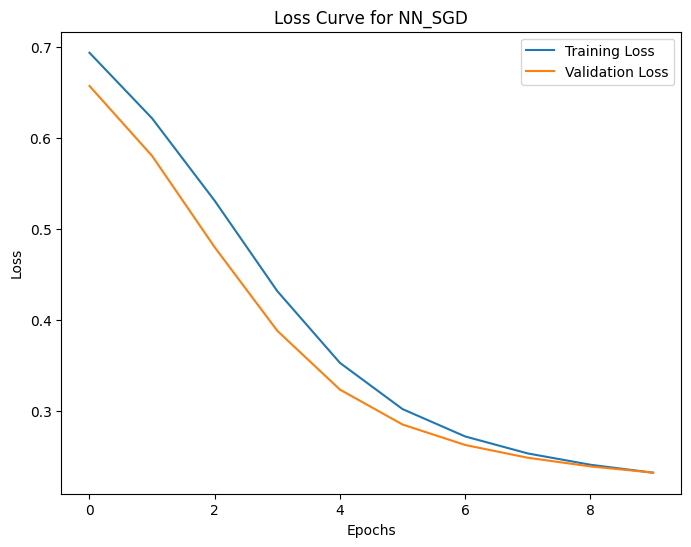

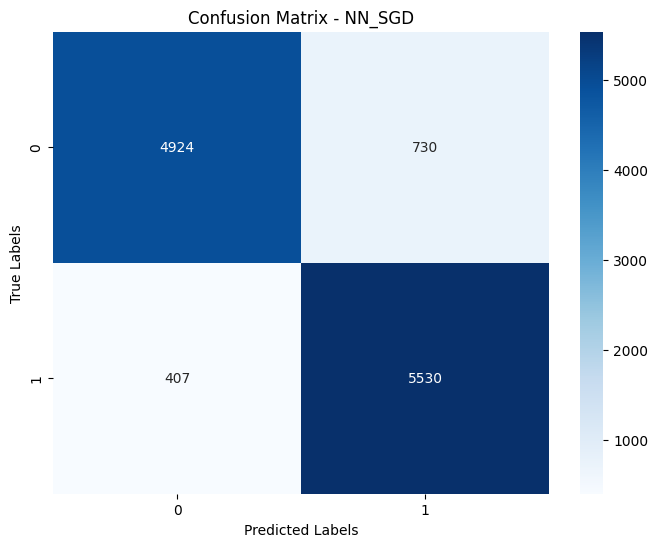

In [15]:
# Train and evaluate the model with SGD optimizer
print("\nTraining Neural Network Model with SGD Optimizer...")
sgd_model, sgd_callbacks = define_model(optimizer='sgd', early_stopping=True, learning_rate=0.001)
sgd_metrics = train_and_evaluate_model(sgd_model, sgd_callbacks, X_train, y_train, X_val, y_val, X_test, y_test, model_name="NN_SGD")

# Train and evaluate the model with RMSprop optimizer


Training Neural Network Model with RMSprop Optimizer...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1691/1691 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8659 - loss: 0.3078 - val_accuracy: 0.9171 - val_loss: 0.1942
Epoch 2/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9247 - loss: 0.1870 - val_accuracy: 0.9227 - val_loss: 0.1827
Epoch 3/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9270 - loss: 0.1807 - val_accuracy: 0.9223 - val_loss: 0.1766
Epoch 4/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9295 - loss: 0.1733 - val_accuracy: 0.9244 - val_loss: 0.1704
Epoch 5/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9314 - loss: 0.1660 - val_accuracy: 0.9276 - val_loss: 0.1671
Epoch 6/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9335 - loss: 0.1627 - val_accuracy: 0.9308 - val_loss: 0.1666
Epoch 7/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9336 - loss: 0.1619 - val_accuracy: 0.9304 - val_loss: 0.1702
Epoch 8/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9316 - loss: 0.1658 - val_accurac

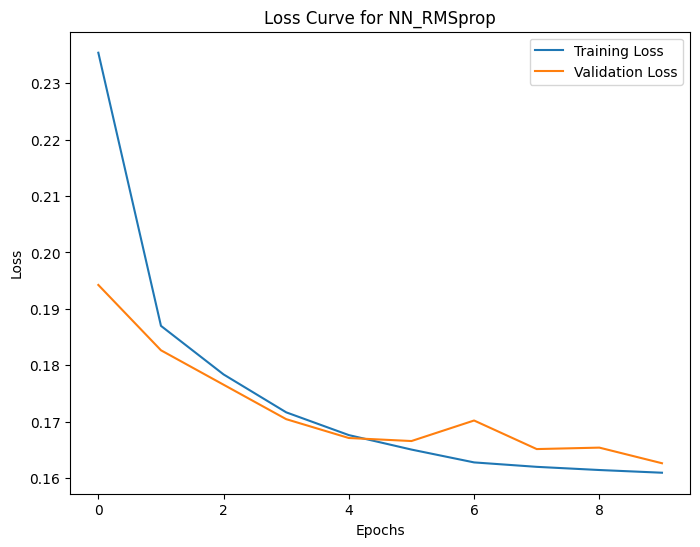

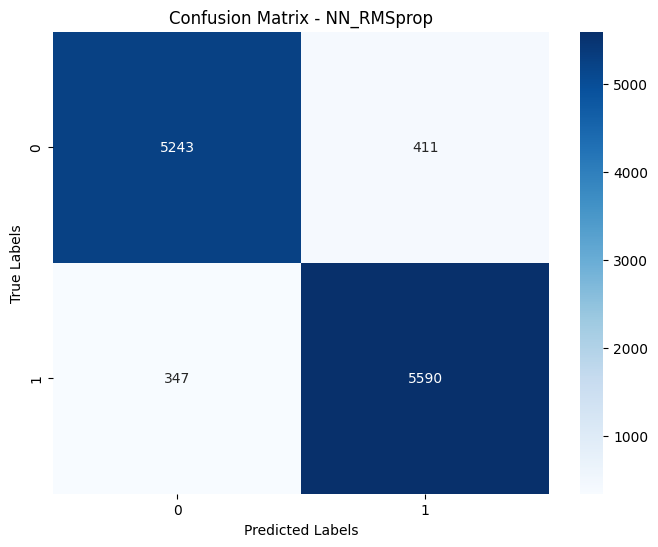

In [16]:
# Train and evaluate the model with RMSprop optimizer
print("\nTraining Neural Network Model with RMSprop Optimizer...")
rmsprop_model, rmsprop_callbacks = define_model(optimizer='rmsprop', early_stopping=True, learning_rate=0.001)
rmsprop_metrics = train_and_evaluate_model(rmsprop_model, rmsprop_callbacks, X_train, y_train, X_val, y_val, X_test, y_test, model_name="NN_RMSprop")

# Store all metrics for comparison

Save the best model to disk

In [17]:
# Store all metrics for comparison
all_metrics = [optimized_metrics, sgd_metrics, rmsprop_metrics]

# Save all models to disk
for metrics in all_metrics:
    model = metrics['Model']
    model_name = metrics['Model Name']
    file_name = f"{model_name.lower().replace(' ', '_')}.h5"
    model.save(file_name)
    print(f"Model '{model_name}' saved as '{file_name}'.")

# Find the best model based on F1 score
best_model_info = max(all_metrics, key=lambda x: x['F1 Score'])
best_model = best_model_info['Model']
best_model_name = best_model_info['Model Name']

print(f"\nBest Model: {best_model_name} with F1 Score: {best_model_info['F1 Score']:.4f}")

# Save the best model separately
best_model.save("best_model.h5")
print("Best model saved as 'best_model.h5'.")

# Display all model performances for comparison
print("\nAll Model Performances:")
for metrics in all_metrics:
    print(f"{metrics['Model Name']}:")
    print(f"  Accuracy: {metrics['Accuracy'] * 100:.2f}%")
    print(f"  F1 Score: {metrics['F1 Score']:.4f}")
    print(f"  Recall: {metrics['Recall']:.4f}")
    print(f"  Precision: {metrics['Precision']:.4f}")

Model 'Optimized_NN_Adam' saved as 'optimized_nn_adam.h5'.
Model 'NN_SGD' saved as 'nn_sgd.h5'.
Model 'NN_RMSprop' saved as 'nn_rmsprop.h5'.

Best Model: Optimized_NN_Adam with F1 Score: 0.9378
Best model saved as 'best_model.h5'.

All Model Performances:
Optimized_NN_Adam:
  Accuracy: 93.64%
  F1 Score: 0.9378
  Recall: 0.9352
  Precision: 0.9404
NN_SGD:
  Accuracy: 90.19%
  F1 Score: 0.9068
  Recall: 0.9314
  Precision: 0.8834
NN_RMSprop:
  Accuracy: 93.46%
  F1 Score: 0.9365
  Recall: 0.9416
  Precision: 0.9315


# SECTION 2: Optimization and Regularization Combinations
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose

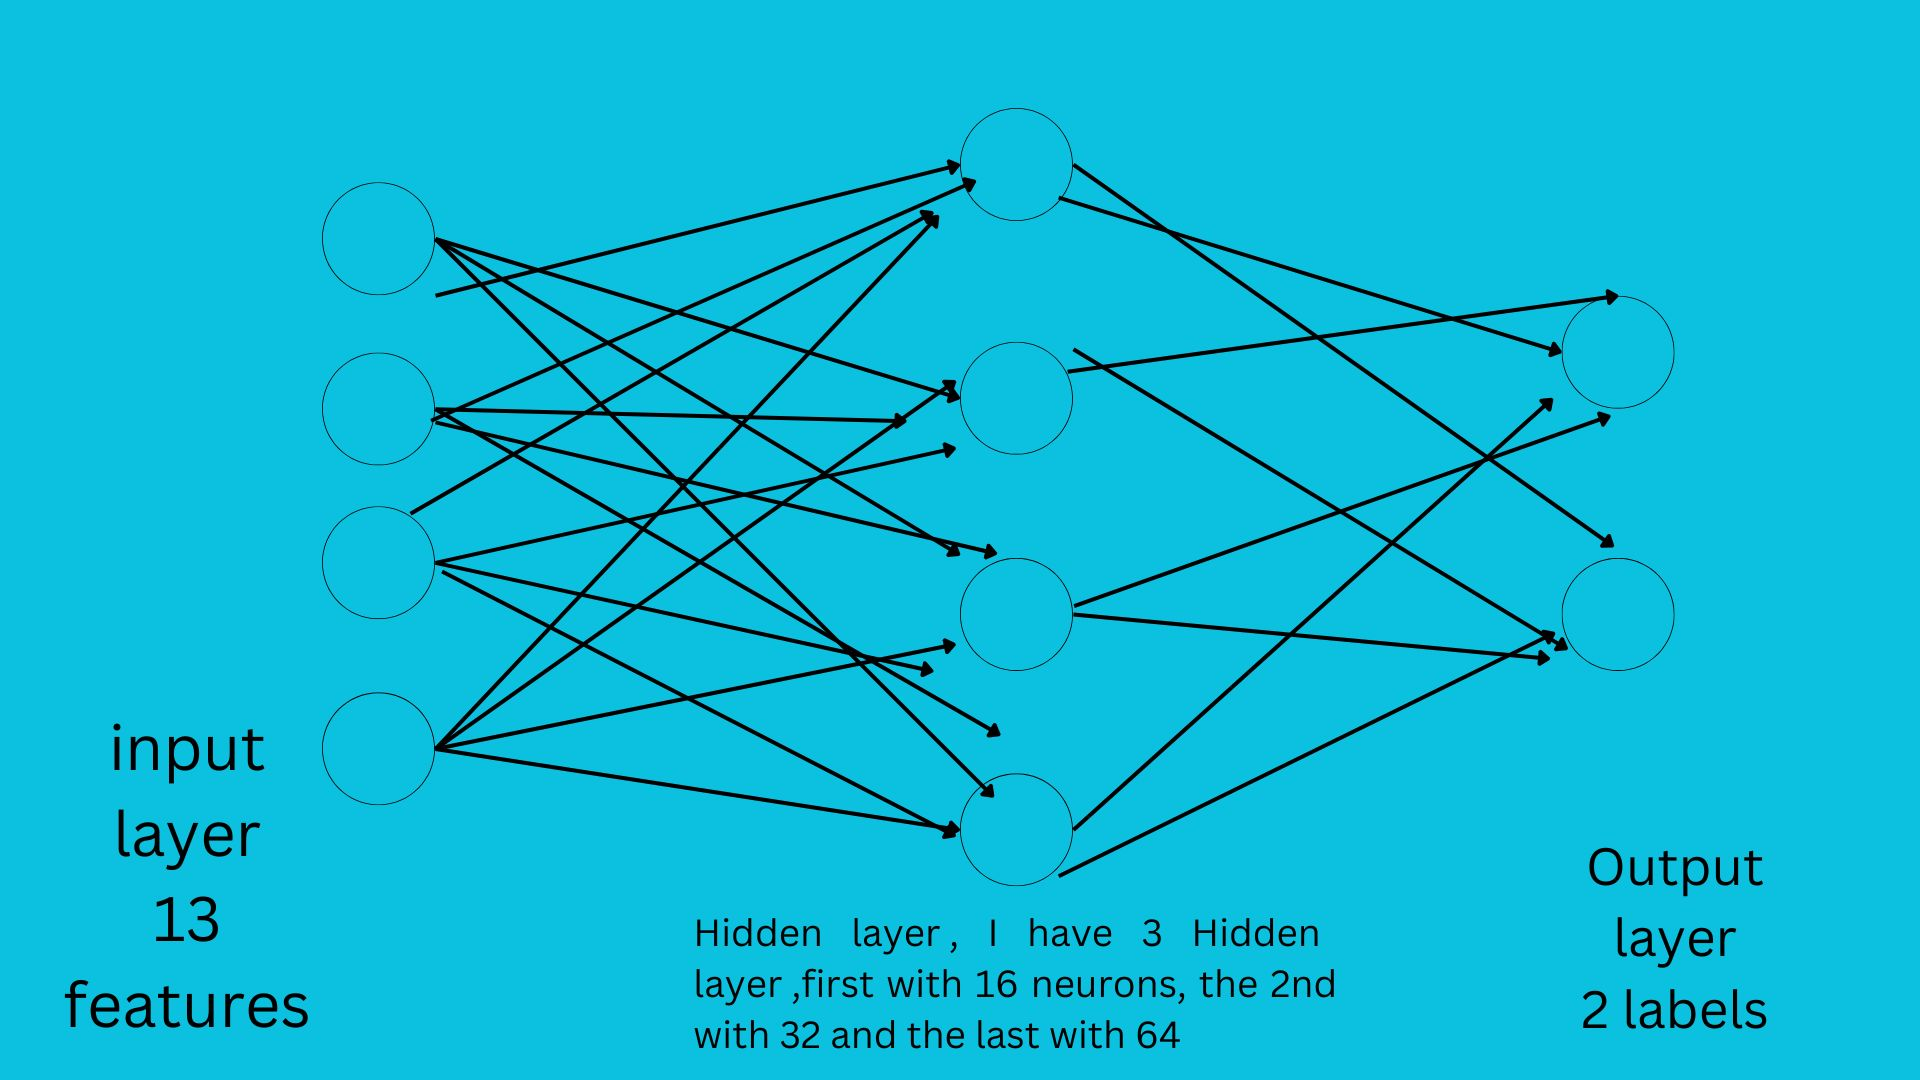

In [18]:
def define_model(optimizer='sgd', regularization=None, dropout_rate=0.0, early_stopping=False, learning_rate=0.001):
    model = Sequential()

    # Input layer with optional regularization
    if regularization == 'l1':
        model.add(Dense(16, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l1(0.01)))
    elif regularization == 'l2':
        model.add(Dense(16, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)))
    else:
        model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))

    # Add dropout if specified
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))

    # Hidden layer with optional regularization
    if regularization == 'l1':
        model.add(Dense(32, activation='relu', kernel_regularizer=l1(0.01)))
    elif regularization == 'l2':
        model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
    else:
        model.add(Dense(32, activation='relu'))

    # Hidden layer with optional regularization
    if regularization == 'l1':
        model.add(Dense(64, activation='relu', kernel_regularizer=l1(0.01)))
    elif regularization == 'l2':
        model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    else:
        model.add(Dense(64, activation='relu'))

    # Add dropout if specified
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Define the optimizer
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unsupported optimization technique: {optimizer}")

    # Compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Define early stopping if required
    callbacks = []
    if early_stopping:
        callbacks.append(EarlyStopping(monitor='val_loss', patience=5))

    return model, callbacks

def train_and_evaluate_model(model, callbacks, X_train, y_train, X_val, y_val, X_test, y_test, epochs=10, model_name="model"):
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=callbacks, verbose=1)

    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    print(f"\nFinal Model Metrics for {model_name}:")
    print(f"Accuracy: {test_accuracy * 100:.2f}%")
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")

    # Loss curve
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curve for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()


    return {
        'Model Name': model_name,
        'Model': model,
        'Accuracy': test_accuracy,
        'F1 Score': f1,
        'Recall': recall,
        'Precision': precision
    }


#Training Neural Network Model with L2 Regularization


Training Neural Network Model with L2 Regularization...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1691/1691 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6341 - loss: 1.4621 - val_accuracy: 0.7518 - val_loss: 1.3591
Epoch 2/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7742 - loss: 1.3236 - val_accuracy: 0.8226 - val_loss: 1.2101
Epoch 3/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8336 - loss: 1.1708 - val_accuracy: 0.8640 - val_loss: 1.0635
Epoch 4/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8669 - loss: 1.0366 - val_accuracy: 0.8853 - val_loss: 0.9557
Epoch 5/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8885 - loss: 0.9395 - val_accuracy: 0.8960 - val_loss: 0.8826
Epoch 6/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8981 - loss: 0.8724 - val_accuracy: 0.9032 - val_loss: 0.8281
Epoch 7/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9016 - loss: 0.8219 - val_accuracy: 0.9060 - val_loss: 0.7834
Epoch 8/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9057 - loss: 0.7756 - val_accurac

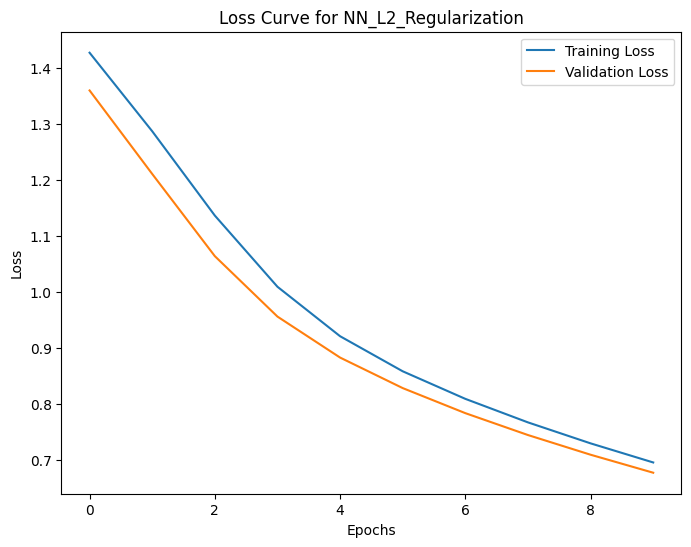

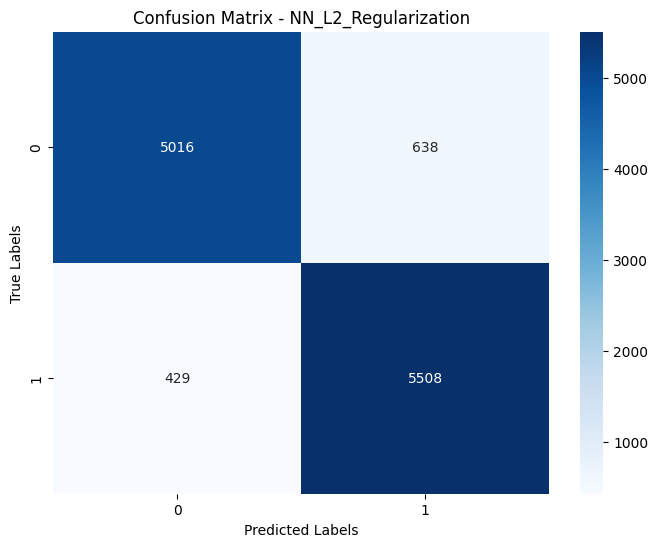

In [19]:
print("\nTraining Neural Network Model with L2 Regularization...")
l2_model, l2_callbacks = define_model(regularization='l2', early_stopping=True)
l2_metrics = train_and_evaluate_model(l2_model, l2_callbacks, X_train, y_train, X_val, y_val, X_test, y_test, model_name="NN_L2_Regularization")

#Training Neural Network Model with Dropout


Training Neural Network Model with Dropout...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1691/1691 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.4941 - loss: 0.7036 - val_accuracy: 0.6607 - val_loss: 0.6543
Epoch 2/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.6340 - loss: 0.6455 - val_accuracy: 0.7538 - val_loss: 0.5943
Epoch 3/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7232 - loss: 0.5841 - val_accuracy: 0.8137 - val_loss: 0.5087
Epoch 4/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7822 - loss: 0.5075 - val_accuracy: 0.8502 - val_loss: 0.4138
Epoch 5/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8252 - loss: 0.4274 - val_accuracy: 0.8713 - val_loss: 0.3395
Epoch 6/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8488 - loss: 0.3712 - val_accuracy: 0.8852 - val_loss: 0.2926
Epoch 7/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8641 - loss: 0.3287 - val_accuracy: 0.8928 - val_loss: 0.2652
Epoch 8/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8742 - loss: 0.3103 - val_accura

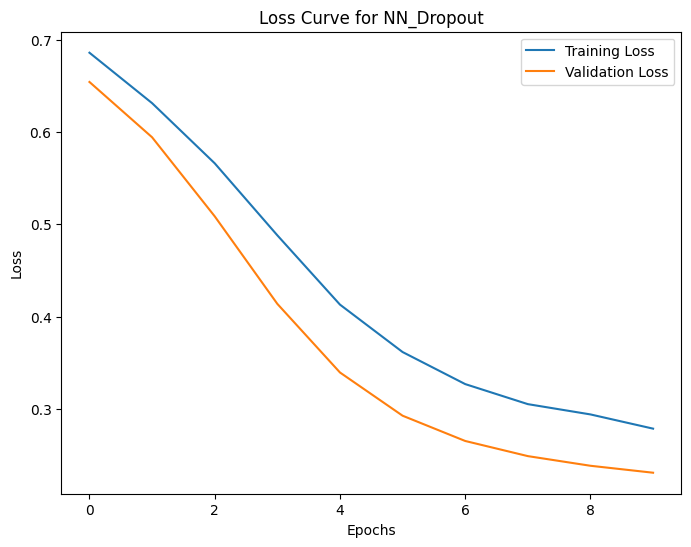

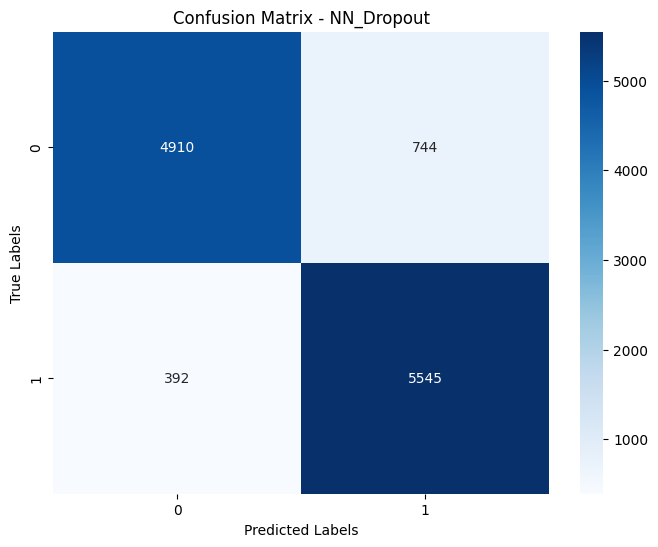

In [21]:
print("\nTraining Neural Network Model with Dropout...")
dropout_model, dropout_callbacks = define_model(dropout_rate=0.2, early_stopping=True)
dropout_metrics = train_and_evaluate_model(dropout_model, dropout_callbacks, X_train, y_train, X_val, y_val, X_test, y_test, model_name="NN_Dropout")

#Training Model with RMSprop Optimizer and L1 Regularization


Training Model with RMSprop Optimizer and L1 Regularization...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8533 - loss: 1.4194 - val_accuracy: 0.9133 - val_loss: 0.3691
Epoch 2/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9135 - loss: 0.3556 - val_accuracy: 0.9135 - val_loss: 0.3294
Epoch 3/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9145 - loss: 0.3241 - val_accuracy: 0.9168 - val_loss: 0.3120
Epoch 4/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9145 - loss: 0.3104 - val_accuracy: 0.9119 - val_loss: 0.3029
Epoch 5/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9178 - loss: 0.2969 - val_accuracy: 0.9125 - val_loss: 0.2931
Epoch 6/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9160 - loss: 0.2890 - val_accuracy: 0.9166 - val_loss: 0.2901
Epoch 7/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9183 - loss: 0.2863 - val_accuracy: 0.9148 - val_loss: 0.2858
Epoch 8/10
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9163 - loss: 0.2850 - 

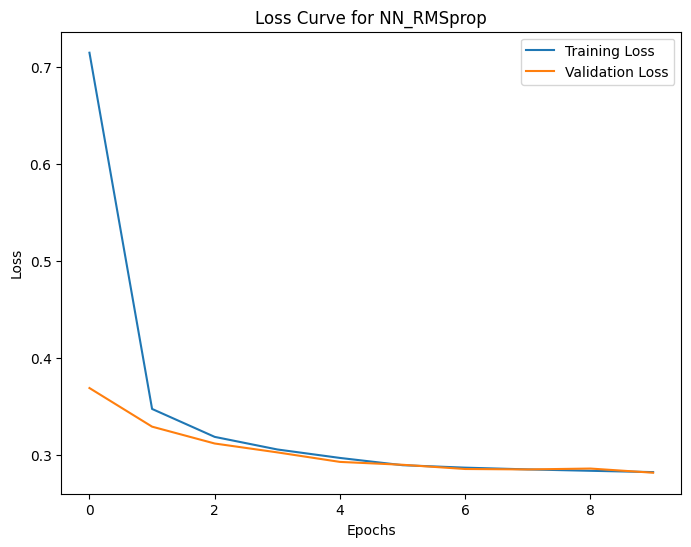

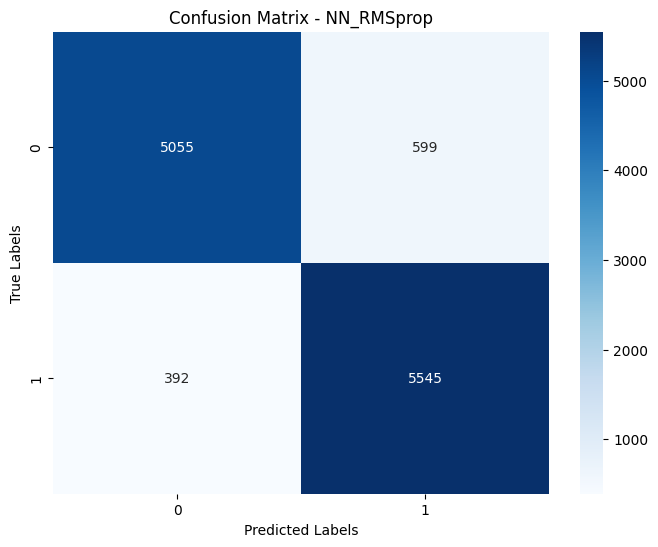

In [20]:
print("\nTraining Model with RMSprop Optimizer and L1 Regularization...")
model_rmsprop_l1, callbacks = define_model(optimizer='rmsprop', regularization='l1', early_stopping=True, learning_rate=0.001)
l1_metrics = train_and_evaluate_model(model_rmsprop_l1, callbacks, X_train, y_train, X_val, y_val, X_test, y_test , model_name="NN_RMSprop")

# Store all metrics for comparison for optmized and regularized models

In [22]:
# Store all metrics for comparison
all_metrics = [l2_metrics, dropout_metrics, l1_metrics]

# Save all models to disk
for metrics in all_metrics:
    model = metrics['Model']
    model_name = metrics['Model Name']
    file_name = f"{model_name.lower().replace(' ', '_')}.h5"
    model.save(file_name)
    print(f"Model '{model_name}' saved as '{file_name}'.")

# Find the best model based on F1 score
best_model_info = max(all_metrics, key=lambda x: x['F1 Score'])
best_model = best_model_info['Model']
best_model_name = best_model_info['Model Name']

print(f"\nBest Model: {best_model_name} with F1 Score: {best_model_info['F1 Score']:.4f}")

# Save the best model separately
best_model.save("best_model_reg.h5")
print("Best model saved as 'best_model_reg.h5'.")

Model 'NN_L2_Regularization' saved as 'nn_l2_regularization.h5'.
Model 'NN_Dropout' saved as 'nn_dropout.h5'.
Model 'NN_RMSprop' saved as 'nn_rmsprop.h5'.

Best Model: NN_RMSprop with F1 Score: 0.9180
Best model saved as 'best_model_reg.h5'.


#Task: Make Predictions using the best saved model


Finally, Make predictions using the best model. By the time you get to this cell you may realise at some point you needed to save the model so that you cal load it later

In [23]:
def make_predictions(model_path, X):
    # Load the trained model from the given path
    model = load_model(model_path)

    # Make predictions (output probabilities)
    probabilities = model.predict(X)

    # Convert probabilities to binary labels (0 or 1) using a threshold of 0.5
    predictions = (probabilities > 0.5).astype(int)

    return predictions

In [24]:
best_model_path = "best_model.h5"  # Path where the best model is saved
X_new = X_test

# Get predictions
predicted_labels = make_predictions(best_model_path, X_new)

# Print the first 10 predictions
print(predicted_labels[:10])

363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[[1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]]


In [25]:
best_model_path = "best_model_reg.h5"  # Path where the best model is saved
X_new = X_test

# Get predictions
predicted_labels = make_predictions(best_model_path, X_new)

# Print the first 10 predictions
print(predicted_labels[:10])

363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[[1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]]


Congratulations!!
